# Week 5: Hyperparameter Tuning + Cross-Validation

**Goal:** Get confident with model selection by doing proper cross-validation and hyperparameter tuning (Grid/Randomized search) on both a classification and a regression task, plus quick diagnostics (confusion matrix, ROC, learning curves).

## Part A — Setup & Utilities

### Cell A1 — Imports & helpers

**Purpose:** Load core libs once; define a tiny helper to print CV summaries.

In [1]:
# === Cell A1: imports & helpers ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold,
    cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, learning_curve
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, mean_squared_error
)

# For randomized search distributions
from scipy.stats import loguniform, randint

# Reproducibility everywhere
RNG_SEED = 42
np.random.seed(RNG_SEED)

def print_cv_summary(name, scores, greater_is_better=True):
    mean = np.mean(scores)
    std = np.std(scores)
    arrow = "↑" if greater_is_better else "↓"
    print(f"{name}: {mean:.4f} ± {std:.4f} {arrow} (cv={len(scores)})")

## Part B — Classification (Breast Cancer)

### Cell B1 — Load dataset + stratified split

**Purpose:** Get X/y and keep class balance in both train/test via stratification.

In [2]:
# === Cell B1: load Breast Cancer dataset ===
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)

df = data.frame.copy()
X = df.drop(columns=["target"])
y = df["target"]  # 0/1 labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RNG_SEED
)

print("Train/Test shapes:", X_train.shape, X_test.shape)
print("Class balance (train):", y_train.mean())
print("Class balance (test):", y_test.mean())

Train/Test shapes: (426, 30) (143, 30)
Class balance (train): 0.6267605633802817
Class balance (test): 0.6293706293706294


### Cell B2 — Baseline with CV (Logistic Regression)

**Purpose:** Establish a clean baseline using a Pipeline + 5-fold CV on multiple metrics.

In [3]:
# === Cell B2: baseline logistic regression with CV ===
from sklearn.linear_model import LogisticRegression

baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=RNG_SEED))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG_SEED)
acc_scores = cross_val_score(baseline_pipe, X_train, y_train, cv=cv, scoring="accuracy")
f1_scores  = cross_val_score(baseline_pipe, X_train, y_train, cv=cv, scoring="f1")
roc_scores = cross_val_score(baseline_pipe, X_train, y_train, cv=cv, scoring="roc_auc")

print_cv_summary("Baseline ACC", acc_scores)
print_cv_summary("Baseline F1",  f1_scores)
print_cv_summary("Baseline ROC-AUC", roc_scores)

Baseline ACC: 0.9789 ± 0.0088 ↑ (cv=5)
Baseline F1: 0.9833 ± 0.0070 ↑ (cv=5)
Baseline ROC-AUC: 0.9962 ± 0.0040 ↑ (cv=5)


### Cell B3 — Fit baseline, evaluate on test

**Purpose:** See how the baseline generalizes to the held-out test set with visuals.

Test Accuracy: 0.986013986013986
Test F1: 0.9888888888888889
Test ROC-AUC: 0.9976939203354298


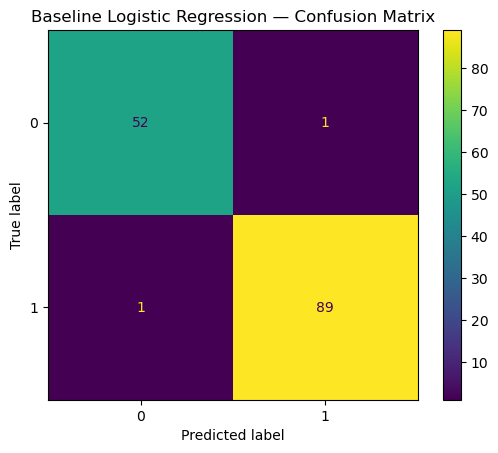

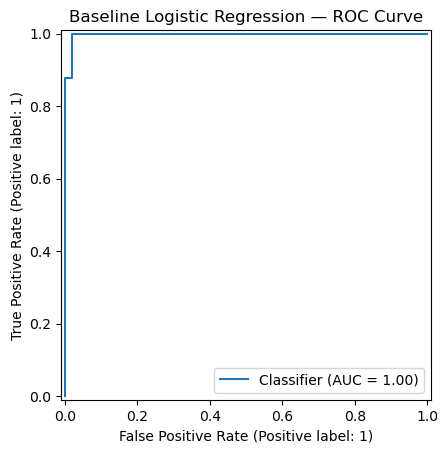

In [4]:
# === Cell B3: fit baseline & evaluate on test ===
baseline_pipe.fit(X_train, y_train)
y_proba = baseline_pipe.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Baseline Logistic Regression — Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Baseline Logistic Regression — ROC Curve")
plt.show()

### Cell B4 — GridSearchCV (Logistic Regression)

**Purpose:** Tune C and penalty to see if the linear model can improve AUC.

In [5]:
# === Cell B4: grid search for Logistic Regression (C + penalty) ===
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear", random_state=RNG_SEED))
])

param_grid = {
    "clf__C": np.logspace(-3, 3, 13),    # 0.001 to 1000
    "clf__penalty": ["l1", "l2"]
}

grid_logreg = GridSearchCV(
    logreg_pipe, param_grid=param_grid, cv=cv,
    scoring="roc_auc", n_jobs=-1, refit=True
)
grid_logreg.fit(X_train, y_train)

print("Best ROC-AUC (cv):", grid_logreg.best_score_)
print("Best params:", grid_logreg.best_params_)

best_logreg = grid_logreg.best_estimator_
proba = best_logreg.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)
print("Test ROC-AUC:", roc_auc_score(y_test, proba))
print("Test F1:", f1_score(y_test, pred))

Best ROC-AUC (cv): 0.9962657232704402
Best params: {'clf__C': 0.31622776601683794, 'clf__penalty': 'l2'}
Test ROC-AUC: 0.9976939203354298
Test F1: 0.9888888888888889


### Cell B5 — RandomizedSearchCV (SVC with RBF)

**Purpose:** Explore a wider space cheaply for SVC C and gamma using log-distributions.

In [6]:
# === Cell B5: randomized search for SVC (RBF) ===
from sklearn.svm import SVC

svc_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=RNG_SEED))
])

param_dist = {
    "clf__C": loguniform(1e-3, 1e3),
    "clf__gamma": loguniform(1e-4, 1e0),
    "clf__kernel": ["rbf"]
}

rand_svc = RandomizedSearchCV(
    svc_pipe, param_distributions=param_dist,
    n_iter=40, cv=cv, scoring="roc_auc",
    random_state=RNG_SEED, n_jobs=-1, refit=True
)
rand_svc.fit(X_train, y_train)

print("Best ROC-AUC (cv):", rand_svc.best_score_)
print("Best params:", rand_svc.best_params_)

best_svc = rand_svc.best_estimator_
proba = best_svc.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)
print("Test ROC-AUC:", roc_auc_score(y_test, proba))
print("Test F1:", f1_score(y_test, pred))

Best ROC-AUC (cv): 0.9972091194968554
Best params: {'clf__C': 12.746711578215052, 'clf__gamma': 0.005762487216478602, 'clf__kernel': 'rbf'}
Test ROC-AUC: 0.9983228511530399
Test F1: 0.9832402234636871


### Cell B6 — GridSearchCV (RandomForestClassifier)

**Purpose:** Purpose: Cut combos drastically; use 3-fold CV + draw 20 random configs; sub-sample rows per tree.

In [9]:
# === Cell B6-FAST: RandomizedSearchCV(RandomForestClassifier) ===
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

rf = RandomForestClassifier(random_state=RNG_SEED, n_jobs=-1)

# Use 3-fold to speed up; still stratified
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG_SEED)

# Sub-sample each tree for speed (available in sklearn >=1.1)
# If your sklearn is older and errors on max_samples, comment that line out.
param_dist_rf = {
    "n_estimators": randint(150, 401),         # 150–400 trees
    "max_depth": [None, 6, 10, 14],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True],
    "max_samples": [0.6, 0.75, 0.9],           # subsample rows per tree (speed!)
}

rf_rand = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=20,                      # try ~20 random configs
    cv=cv_fast,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=RNG_SEED,
    refit=True,
    verbose=1
)

rf_rand.fit(X_train, y_train)

print("Best ROC-AUC (cv):", rf_rand.best_score_)
print("Best params:", rf_rand.best_params_)

best_rf = rf_rand.best_estimator_
proba = best_rf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)
print("Test ROC-AUC:", roc_auc_score(y_test, proba))
print("Test F1:", f1_score(y_test, pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best ROC-AUC (cv): 0.989188043247827
Best params: {'bootstrap': True, 'max_depth': 6, 'max_features': 'log2', 'max_samples': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 367}
Test ROC-AUC: 0.9935010482180293
Test F1: 0.967032967032967


### Cell B7 — Out-of-fold (OOF) predictions for error analysis

**Purpose:** Generate CV-only predictions to inspect confusion matrix without touching test set.

OOF ROC-AUC: 0.9954302405012603
OOF F1: 0.974169741697417


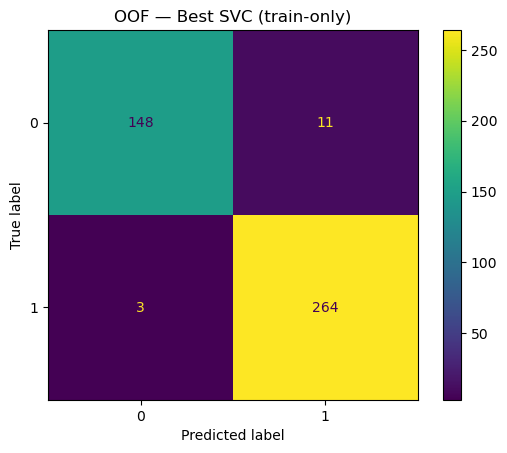

In [10]:
# === Cell B7: OOF predictions for error analysis ===
# Use the strongest model you found; here we pick best_svc
oof_proba = cross_val_predict(
    best_svc, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)

print("OOF ROC-AUC:", roc_auc_score(y_train, oof_proba))
print("OOF F1:", f1_score(y_train, oof_pred))
ConfusionMatrixDisplay.from_predictions(y_train, oof_pred)
plt.title("OOF — Best SVC (train-only)")
plt.show()

## Part C — Regression (Diabetes)

### Cell C1 — Load dataset + split

**Purpose:** Set up a simple regression problem to practice RMSE-based tuning.

In [11]:
# === Cell C1: load Diabetes regression dataset ===
from sklearn.datasets import load_diabetes
reg_data = load_diabetes(as_frame=True)
Xr = reg_data.frame.drop(columns=["target"])
yr = reg_data.frame["target"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.25, random_state=RNG_SEED
)

print("Train/Test shapes:", Xr_train.shape, Xr_test.shape)

Train/Test shapes: (331, 10) (111, 10)


### Cell C2 — Baseline Linear Regression with CV (RMSE)

**Purpose:** Get a baseline RMSE using scaled LinearRegression + KFold CV.

In [12]:
# === Cell C2: baseline LinearRegression (KFold CV, RMSE) ===
from sklearn.linear_model import LinearRegression

reg_cv = KFold(n_splits=5, shuffle=True, random_state=RNG_SEED)
linreg = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

rmse_scores = -cross_val_score(
    linreg, Xr_train, yr_train, cv=reg_cv, scoring="neg_root_mean_squared_error"
)
print_cv_summary("Baseline RMSE", rmse_scores, greater_is_better=False)

Baseline RMSE: 56.1186 ± 3.1326 ↓ (cv=5)


### Cell C3 — Grid search Ridge & Lasso

**Purpose:** Tune alpha regularization to fight overfitting and reduce RMSE.

In [13]:
# === Cell C3: grid search Ridge and Lasso ===
from sklearn.linear_model import Ridge, Lasso

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Ridge(random_state=RNG_SEED))
])

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Lasso(random_state=RNG_SEED, max_iter=5000))
])

alphas = np.logspace(-4, 2, 15)

grid_ridge = GridSearchCV(
    ridge_pipe, {"reg__alpha": alphas}, cv=reg_cv,
    scoring="neg_root_mean_squared_error", n_jobs=-1, refit=True
).fit(Xr_train, yr_train)

grid_lasso = GridSearchCV(
    lasso_pipe, {"reg__alpha": alphas}, cv=reg_cv,
    scoring="neg_root_mean_squared_error", n_jobs=-1, refit=True
).fit(Xr_train, yr_train)

print("Best Ridge RMSE (cv):", -grid_ridge.best_score_, "alpha:", grid_ridge.best_params_["reg__alpha"])
print("Best Lasso RMSE (cv):", -grid_lasso.best_score_, "alpha:", grid_lasso.best_params_["reg__alpha"])

Best Ridge RMSE (cv): 56.07020281736068 alpha: 1.9306977288832496
Best Lasso RMSE (cv): 56.05561325134204 alpha: 0.1


### Cell C4 — RandomizedSearchCV (RandomForestRegressor)

**Purpose:** Goal: Keep RF but make it fast: fewer configs, 3-fold CV, fewer trees, subsample rows.

In [15]:
# === Cell C4-FAST: RandomizedSearchCV(RandomForestRegressor) ===
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

rfr = RandomForestRegressor(random_state=RNG_SEED, n_jobs=-1)

# 3-fold CV to cut time ~40%
cv_fast = KFold(n_splits=3, shuffle=True, random_state=RNG_SEED)

# Subsample rows per tree with max_samples (sklearn >=1.1). If error, remove max_samples.
param_dist_rfr = {
    "n_estimators": randint(120, 301),        # fewer trees = much faster
    "max_depth": [None, 6, 10, 14],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True],
    "max_samples": [0.6, 0.8, 0.95],
}

rand_rfr = RandomizedSearchCV(
    rfr,
    param_distributions=param_dist_rfr,
    n_iter=20,                          # 20 configs instead of 40
    cv=cv_fast,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=RNG_SEED,
    refit=True,
    verbose=1
)

rand_rfr.fit(Xr_train, yr_train)

print("Best RF RMSE (cv):", -rand_rfr.best_score_)
print("Best params:", rand_rfr.best_params_)

best_rfr = rand_rfr.best_estimator_
pred = best_rfr.predict(Xr_test)
rmse = mean_squared_error(yr_test, pred, squared=False)
print("Test RMSE:", rmse)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF RMSE (cv): 58.247699162836284
Best params: {'bootstrap': True, 'max_depth': 6, 'max_features': 'log2', 'max_samples': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 159}
Test RMSE: 52.721831614972785


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Part D — (Optional) Learning Curves & Leaderboard

### Cell D1 — Learning curve helper

**Purpose:** Visualize under/overfitting patterns and data needs.

In [16]:
# === Cell D1: learning curve plotter (single model) ===
def plot_learning_curve(estimator, X, y, cv, scoring="accuracy", title="Learning Curve"):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, marker='o', label="Training score")
    plt.plot(train_sizes, val_mean, marker='o', label="Validation score")
    plt.xlabel("Training examples"); plt.ylabel(scoring)
    plt.title(title); plt.legend(); plt.grid(True)
    plt.show()

### Cell D2 — Learning curves (compare two classifiers)

**Purpose:** See capacity differences between tuned SVC and tuned Logistic.

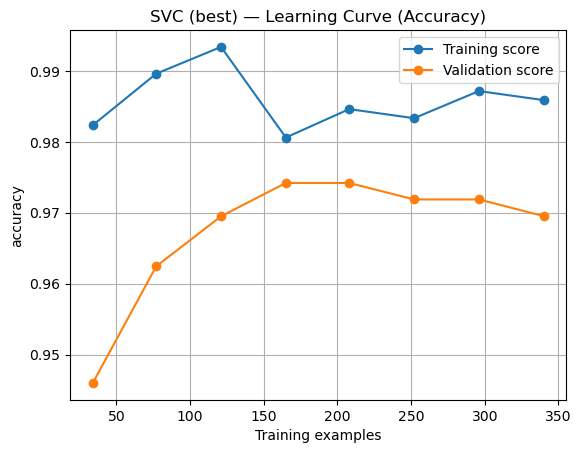

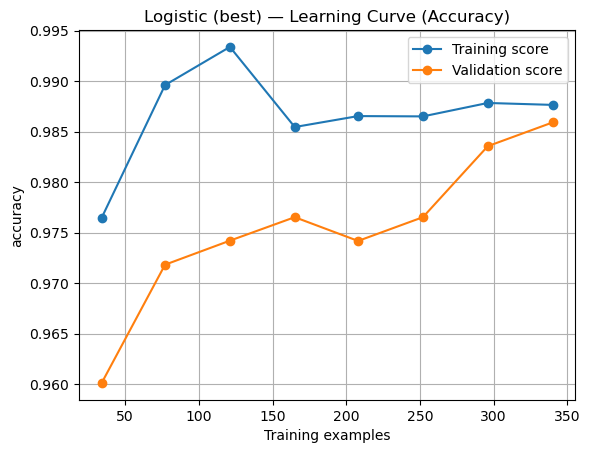

In [17]:
# === Cell D2: compare curves (classification) ===
plot_learning_curve(best_svc, X_train, y_train, cv=cv, scoring="accuracy",
                    title="SVC (best) — Learning Curve (Accuracy)")
plot_learning_curve(best_logreg, X_train, y_train, cv=cv, scoring="accuracy",
                    title="Logistic (best) — Learning Curve (Accuracy)")

### Cell D3 — Quick model leaderboard (classification)

**Purpose:** Rank candidates by ROC-AUC via 5-fold CV.

In [18]:
# === Cell D3: model comparison leaderboard (cv on train) ===
models = {
    "Baseline_LogReg": baseline_pipe,
    "Best_LogReg": best_logreg,
    "Best_SVC": best_svc,
    "Best_RF": best_rf
}

for name, mdl in models.items():
    scores = cross_val_score(mdl, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    print_cv_summary(f"{name} ROC-AUC", scores)

Baseline_LogReg ROC-AUC: 0.9962 ± 0.0040 ↑ (cv=5)
Best_LogReg ROC-AUC: 0.9963 ± 0.0036 ↑ (cv=5)
Best_SVC ROC-AUC: 0.9972 ± 0.0039 ↑ (cv=5)
Best_RF ROC-AUC: 0.9879 ± 0.0113 ↑ (cv=5)
